In [2]:
## Import libaries
import pandas as pd
import numpy as np
import re
from IPython.display import clear_output
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import random
pd.options.display.max_columns = None

In [3]:
lib_comments = pd.read_csv('../data/liberal_comments.csv')
lib_posts = pd.read_csv('../data/liberal_posts.csv')
cons_comments = pd.read_csv('../data/conservative_comments.csv')
cons_posts = pd.read_csv('../data/conservative_posts.csv')

In [4]:
lib_posts['political_lean'] = 'liberal'
lib_comments['political_lean'] = 'liberal'
cons_posts['political_lean'] = 'conservative'
cons_comments['political_lean'] = 'conservative'

In [5]:
posts_merged = pd.concat([lib_posts, cons_posts])
comments_merged = pd.concat([cons_comments, lib_comments])
posts_merged.reset_index(drop=True, inplace=True)
comments_merged.reset_index(drop=True, inplace=True)

In [6]:
def fill_nans(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna('', inplace=True)
        elif df[col].dtype == 'float':
            df[col].fillna(0, inplace=True)
        else:
            pass
        
fill_nans(posts_merged)
fill_nans(comments_merged)

In [7]:
def text_stem(text):
    tokenizer = RegexpTokenizer(r'[A-Za-z]{2,}') # What about apostrophes? 
    stemmer = PorterStemmer() #### Could try stemming later
    text = re.sub(r'http\w:[\w\/\?.-]*','', text.lower()) # Removes URLs
#     text = re.sub(r'[a-z]','', text.lower()) # 
    tokens = tokenizer.tokenize(text)
    stemmed_tokes = [stemmer.stem(i) for i in tokens]
    stops = [stemmer.stem(sw) for sw in stopwords.words('english')]
    meaningful_tokens = [w for w in stemmed_tokes if not w in stops] ## Try without?!?
    return (' '.join(meaningful_tokens))

In [8]:
def text_lemma(text):
    tokenizer = RegexpTokenizer(r'[A-Za-z]{2,}') # What about apostrophes?
    lemmatizer = WordNetLemmatizer() #### Could try stemming later
    text = re.sub(r'http\w:[\w\/\?.-]*','', text.lower()) # Removes URLs
#     text = re.sub(r'[a-z]','', text.lower()) # 
    tokens = tokenizer.tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(i) for i in tokens]
    stops = [lemmatizer.lemmatize(sw) for sw in stopwords.words('english')]
    meaningful_tokens = [w for w in lemmatized_tokens if not w in stops] ## Try without?!?
    return (' '.join(meaningful_tokens))

In [9]:
posts_merged['text_stem'] = [text_stem(i) for i in posts_merged['text']]
comments_merged['text_stem'] = [text_stem(i) for i in comments_merged['text']]
posts_merged['title_stem'] = [text_stem(i) for i in posts_merged['title']]

In [10]:
posts_merged['text_lemma'] = [text_lemma(i) for i in posts_merged['text']]
comments_merged['text_lemma'] = [text_lemma(i) for i in comments_merged['text']]
posts_merged['title_lemma'] = [text_lemma(i) for i in posts_merged['title']]

In [11]:
comments_merged['politic_target'] = [1 if i == 'conservative' else 0 for i in comments_merged['political_lean']]
posts_merged['politic_target'] = [1 if i == 'conservative' else 0 for i in posts_merged['political_lean']]

In [12]:
## Removing deleted comments
comments_merged.drop(index = comments_merged[comments_merged['text'] == 'Deleted comment'].index, inplace=True)


#### SHOULD PROBABLY DO THIS BEFORE FILLNA STAGE

## EDA

In [13]:
print('Number of deleted conservative comments:', sum(cons_comments['text'] == 'Deleted comment'))
print('Number of deleted liberal comments:', sum(lib_comments['text'] == 'Deleted comment'))

Number of deleted conservative comments: 102
Number of deleted liberal comments: 298


In [14]:
## Baseline
comments_baseline = max(comments_merged['political_lean'].value_counts(normalize=True))
posts_baseline = max(posts_merged['political_lean'].value_counts(normalize=True))
print('Comments baseline:', round(comments_baseline, 3))
print('Posts baseline:', round(posts_baseline, 3))

Comments baseline: 0.542
Posts baseline: 0.6


## Character & Word Counts

In [15]:
comments_merged['char_count'] = comments_merged['text'].map(len)
comments_merged['word_count'] = comments_merged['text'].map(lambda x: len(x.split()))

In [16]:
num_lib_comms = comments_merged['politic_target'].value_counts()[0]

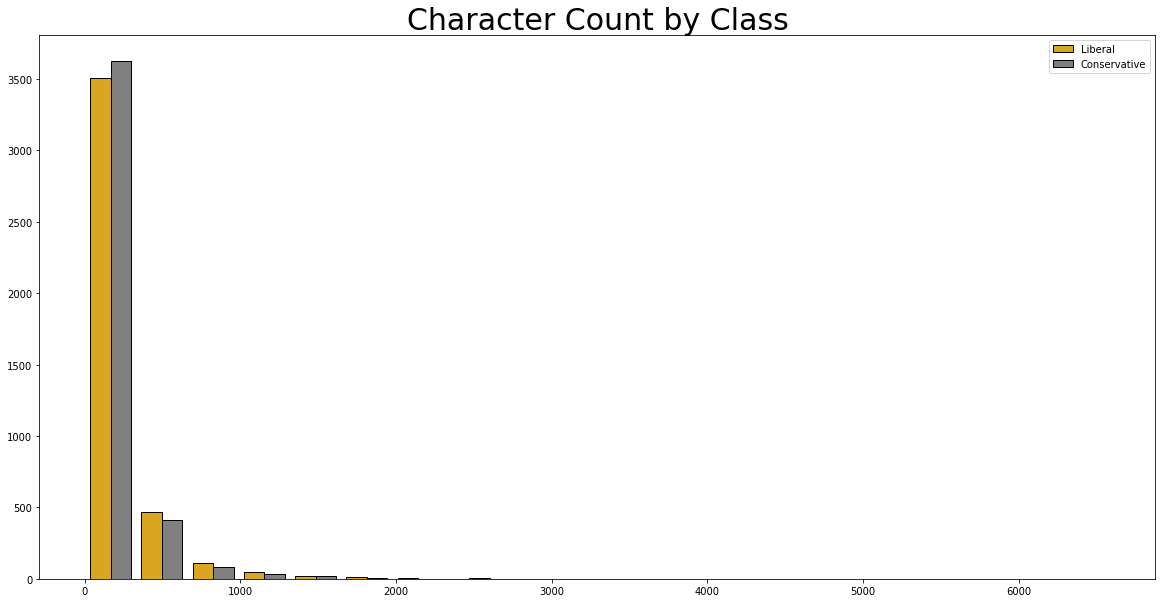

In [17]:
plt.figure(figsize=(20,10))
plt.hist([comments_merged[comments_merged['politic_target']==0]['char_count'],
          random.sample(comments_merged[comments_merged['politic_target']==1]['char_count'].tolist(),
                        k=num_lib_comms)],
         bins=20, color=['goldenrod', 'grey'], ec='k')
plt.title('Character Count by Class', fontsize=30)
plt.legend(['Liberal', 'Conservative']);

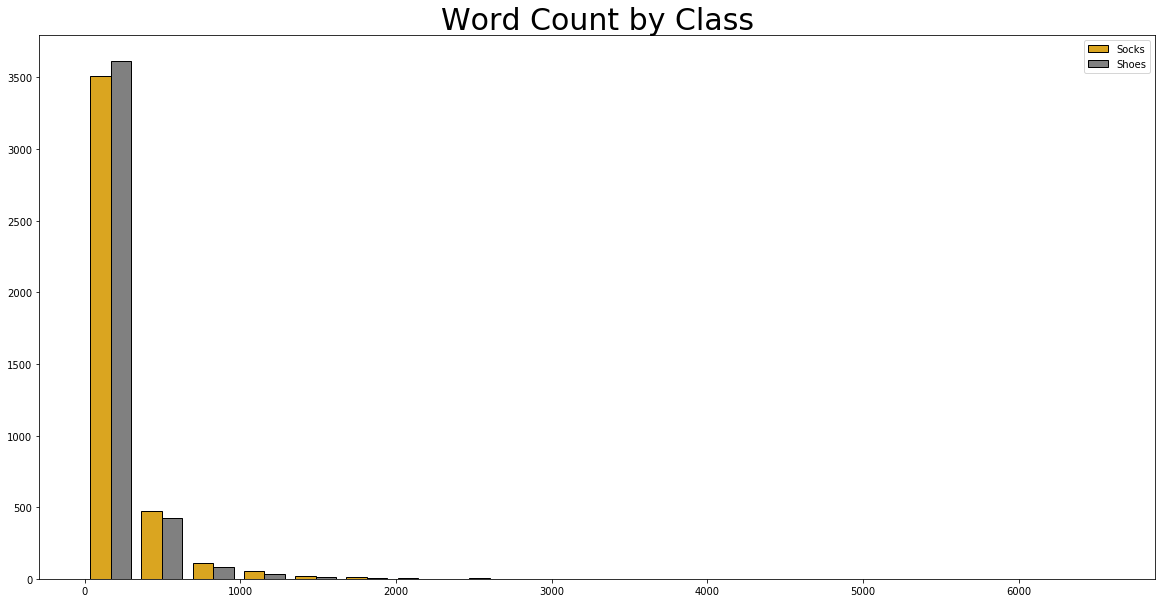

In [18]:
plt.figure(figsize=(20,10))
plt.hist([comments_merged[comments_merged['politic_target']==0]['char_count'],
          random.sample(comments_merged[comments_merged['politic_target']==1]['char_count'].tolist(),
                        k=num_lib_comms)],
         bins=20, color=['goldenrod', 'grey'], ec='k')
plt.title('Word Count by Class', fontsize=30)
plt.legend(['Socks', 'Shoes']);

## Finding meaningful terms

In [19]:
cvec = CountVectorizer(min_df=4, max_df=1.0)
term_mat = cvec.fit_transform(comments_merged['text_lemma'])

In [20]:
term_df = pd.DataFrame(term_mat.toarray(), columns=cvec.get_feature_names())
term_df.insert(0, 'politic_target', comments_merged['politic_target'])
term_df.head()

politic_target  abandon  abc  abiding  ability  able  abolish  aborted  \
0             1.0        0    0        0        0     0        0        0   
1             1.0        0    0        0        0     0        0        0   
2             1.0        0    0        0        0     0        0        0   
3             1.0        0    0        0        0     0        0        0   
4             1.0        0    0        0        0     0        0        0   

   abortion  abrams  absolute  absolutely  absurd  abuse  abused  abusing  \
0         0       0         0           0       0      0       0        0   
1         0       0         0           0       0      0       0        0   
2         0       0         0           0       0      0       0        0   
3         0       0         0           0       0      0       0        0   
4         0       0         0           0       0      0       0        0   

   abusive  aca  academy  accept  acceptable  accepted  accepting  access  \
0        0    0        0       0           0         0          0       0   
1        0    0        0       0           0         0          0       0   
2        0    0        0       0           0         0          0       0   
3        0    0        0       0           0         0          0       0   
4        0    0        0       0           0         0          0       0   

   accident  accidentally  accommodate  accomplice  accomplish  accomplished  \
0         0             0            0           0           0             0   
1         0             0            0           0           0             0   
2         0             0            0           0           0             0   
3         0             0            0           0           0             0   
4         0             0            0           0           0             0   

   accord  according  accordingly  account  accountability  accountable  \
0       0          0            0        0               0            0   
1       0          0            0        0               0            0   
2       0          0            0        0               0            0   
3       0          0            0        0               0            0   
4       0          0            0        0               0            0   

   accounting  accuracy  accurate  accurately  accusation  accuse  accused  \
0           0         0         0           0           0       0        0   
1           0         0         0           0           0       0        0   
2           0         0         0           0           0       0        0   
3           0         0         0           0           0       0        0   
4           0         0         0           0           0       0        0   

   accuser  accusing  achieve  achievement  acknowledge  acquitted  across  \
0        0         0        0            0            0          0       0   
1        0         0        0            0            0          0       0   
2        0         0        0            0            0          0       0   
3        0         0        0            0            0          0       0   
4        0         0        0            0            0          0       0   

   act  acted  acting  action  active  actively  activism  activist  activity  \
0    0      0       0       1       0         0         0         0         0   
1    0      0       0       0       0         0         0         0         0   
2    0      0       0       0       0         0         0         0         0   
3    0      0       0       1       0         0         0         0         0   
4    0      0       0       0       0         0         0         0         0   

   actor  actual  actually  ad  adam  add  added  addict  addiction  adding  \
0      0       0         0   0     0    0      0       0          0       0   
1      0       0         0   0     0    0      0       0          0       0   
2      0       0    

In [21]:
term_df.politic_target

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
5       1.0
6       1.0
7       1.0
8       1.0
9       1.0
10      1.0
11      1.0
12      1.0
13      1.0
14      1.0
15      1.0
16      1.0
17      1.0
18      1.0
19      1.0
20      1.0
21      1.0
22      1.0
23      1.0
24      1.0
25      1.0
26      1.0
27      1.0
28      1.0
29      1.0
       ... 
9115    0.0
9116    0.0
9117    0.0
9118    0.0
9119    0.0
9120    0.0
9121    0.0
9122    0.0
9123    0.0
9124    0.0
9125    0.0
9126    0.0
9127    0.0
9128    0.0
9129    0.0
9130    0.0
9131    0.0
9132    0.0
9133    0.0
9134    0.0
9135    0.0
9136    0.0
9137    0.0
9138    0.0
9139    0.0
9140    0.0
9141    0.0
9142    0.0
9143    0.0
9144    0.0
Name: politic_target, Length: 9145, dtype: float64

In [20]:
term_counts = {col : term_df[col].sum() for col in term_df.columns[1:]}
tcd = pd.DataFrame(term_counts, index = ['counts']).T

In [21]:
tcd.sort_values(by=['counts'], ascending=False).head()

,counts
people,1409
trump,1255
like,1143
would,1024
get,862


In [23]:
top200 = list(tcd.sort_values(by='counts', ascending=False).head(200).index)
top200.append('politic_target')

In [22]:
bottom20corrs = list(term_df[top200].corr()['politic_target'].sort_values().index[:20])
bottom20corrs.insert('politic_target')
top20corrs = list(term_df[top200].corr()['politic_target'].sort_values(ascending=False).index[:21])

NameError: name 'top200' is not defined

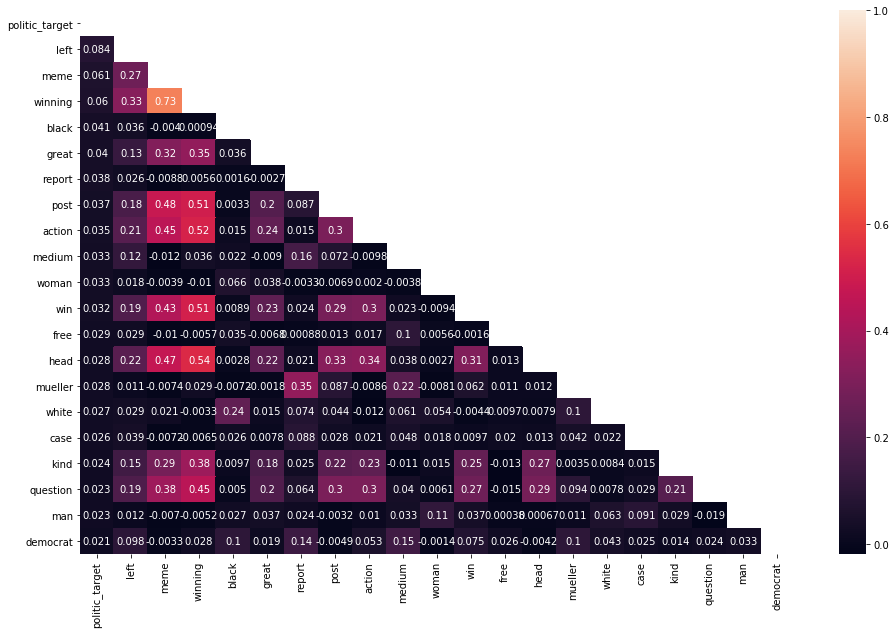

In [41]:
plt.figure(figsize = (16,10))

corr = term_df[top20corrs].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,mask = mask, annot=True);

############ INSIGHTS
# 
#
#
#
############

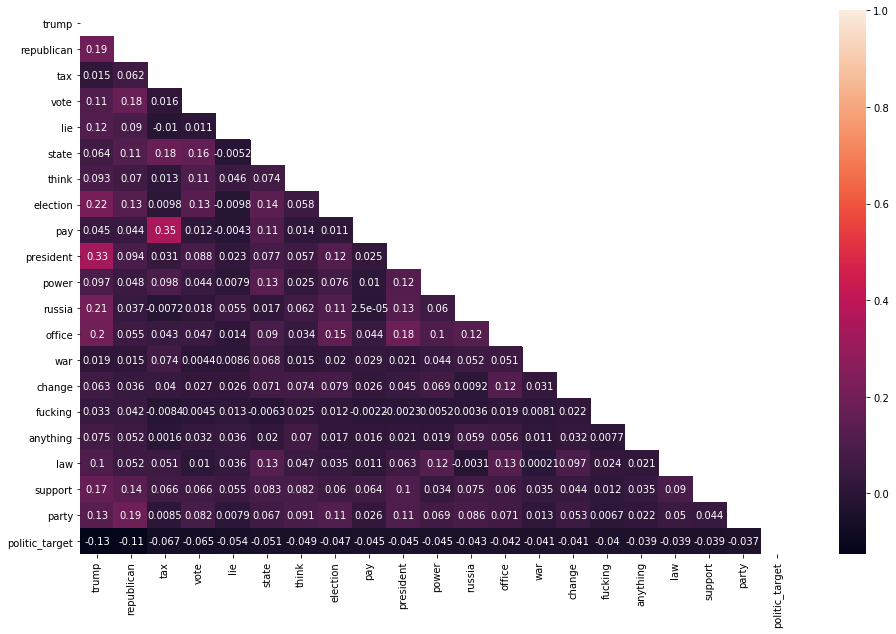

In [42]:
plt.figure(figsize = (16,10))

corr = term_df[bottom20corrs].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,mask = mask, annot=True);

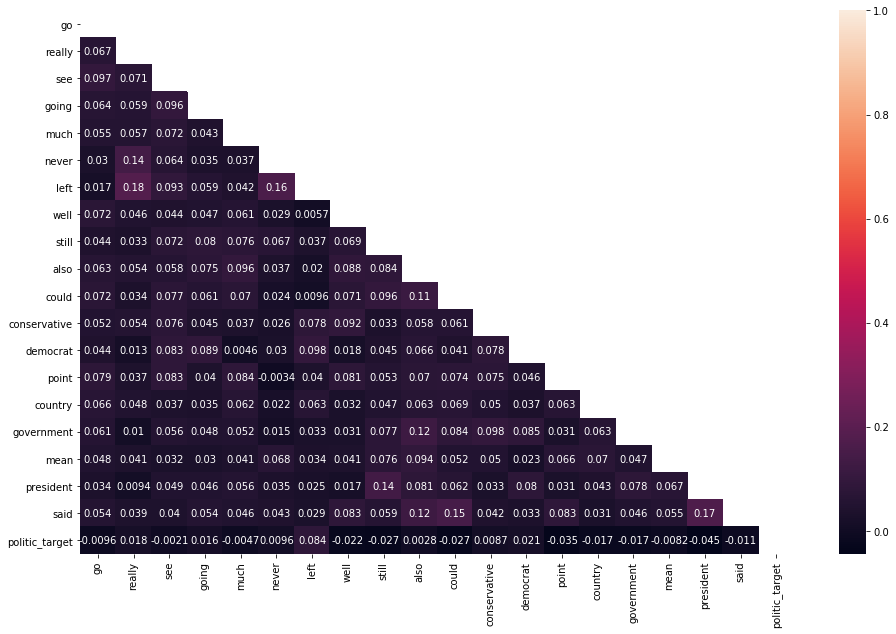

In [92]:
plt.figure(figsize = (16,10))

corr = term_df[top20].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,mask = mask, annot=True);

## Model Setting
This is done more effectively in GridSearchCV below –– DO NOT USE THIS NOW!

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(comments_merged[['text_lemma']],
                                                   comments_merged['politic_target'],
                                                   test_size = .25,
                                                   random_state = 42)

In [ ]:
cvec = CountVectorizer(analyzer = "word",
                       tokenizer = None, #### Can I pass in a function??
                       preprocessor = None,
                       stop_words = None,
                       max_features = 10000,
                       ngram_range=(1,3)) 

X_train_cvec = cvec.fit_transform(X_train['text_lemma'])
X_test_cvec = cvec.transform(X_test['text_lemma'])

logreg = LogisticRegression()
logreg.fit(X_train_cvec, y_train)

print(logreg.score(X_train_cvec, y_train))
print(logreg.score(X_test_cvec, y_test))

In [ ]:
tvec = TfidfVectorizer()

X_train_tvec = tvec.fit_transform(X_train['clean_text'])
X_test_tvec = tvec.transform(X_test['clean_text'])

logreg = LogisticRegression()
logreg.fit(X_train_tvec, y_train)

print(logreg.score(X_train_tvec, y_train))
print(logreg.score(X_test_tvec, y_test))

## Comments Text Analysis Lemma

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(comments_merged[['text_lemma']],
                                                   comments_merged['politic_target'],
                                                   test_size = .25,
                                                   random_state = 42)

In [ ]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear'))
])

params = {
    'cvec__max_features' : [None, 10000, 15000, 20000],
    'cvec__ngram_range' : [(1,2), (1,3), (1,4)]
}

X = posts_merged['text_lemma']
y = posts_merged['politic_target']

gs = GridSearchCV(pipe, param_grid=params, cv=3)
gs.fit(X, y)

print('GS Best Score:',gs.best_score_)
print('GS Best Params:',gs.best_params_)

gs.fit(X_train['text_lemma'], y_train)
print('\nGS Best Params:',gs.best_params_)
print('GS Train Score:',gs.score(X_train['text_lemma'], y_train))
print('GS Test Score:',gs.score(X_test['text_lemma'], y_test))

In [ ]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear'))
])

params = {
    'tvec__max_features' : [None, 5000, 10000, 15000],
    'tvec__ngram_range' : [(1,1), (1,2), (1,3), (1,4)]
}

X = posts_merged['text_lemma']
y = posts_merged['politic_target']

gs = GridSearchCV(pipe, param_grid=params, cv=3)
gs.fit(X, y)
print('\nGS Best Score:',gs.best_score_)
print('GS Best Params:',gs.best_params_)

gs.fit(X_train['text_lemma'], y_train)
print('\nGS Best Params:',gs.best_params_)
print('GS Train Score:',gs.score(X_train['text_lemma'], y_train))
print('GS Test Score:',gs.score(X_test['text_lemma'], y_test))

## Posts Title Analysis

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(posts_merged[['title_lemma']],
                                                   posts_merged['politic_target'],
                                                   test_size = .25,
                                                   random_state = 42)

In [ ]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear'))
])

params = {
    'cvec__max_features' : [None, 10000, 15000, 20000],
    'cvec__ngram_range' : [(1,2), (1,3), (1,4)]
}

X = posts_merged['title_lemma']
y = posts_merged['politic_target']

gs = GridSearchCV(pipe, param_grid=params, cv=3)
gs.fit(X, y)

print('GS Best Score:',gs.best_score_)
print('GS Best Params:',gs.best_params_)

gs.fit(X_train['title_lemma'], y_train)
print('\nGS Best Params:',gs.best_params_)
print('GS Train Score:',gs.score(X_train['title_lemma'], y_train))
print('GS Test Score:',gs.score(X_test['title_lemma'], y_test))

In [ ]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear'))
])

params = {
    'tvec__max_features' : [None, 5000, 10000, 15000],
    'tvec__ngram_range' : [(1,1), (1,2), (1,3), (1,4)]
}

X = posts_merged['title_lemma']
y = posts_merged['politic_target']

gs = GridSearchCV(pipe, param_grid=params, cv=3)
gs.fit(X, y)
print('GS Best Score:',gs.best_score_)
print('GS Best Params:',gs.best_params_)

gs.fit(X_train['title_lemma'], y_train)
print('\nGS Best Params:',gs.best_params_)
print('GS Train Score:',gs.score(X_train['title_lemma'], y_train))
print('GS Test Score:',gs.score(X_test['title_lemma'], y_test))

## Comments Text Analysis Stem

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(comments_merged[['text_stem']],
                                                   comments_merged['politic_target'],
                                                   test_size = .25,
                                                   random_state = 42)

In [ ]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear'))
])

params = {
    'cvec__max_features' : [None, 10000, 15000, 20000],
    'cvec__ngram_range' : [(1,2), (1,3), (1,4)]
}

X = posts_merged['text_stem']
y = posts_merged['politic_target']

gs = GridSearchCV(pipe, param_grid=params, cv=3)
gs.fit(X, y)

print('GS Best Score:',gs.best_score_)
print('GS Best Params:',gs.best_params_)

gs.fit(X_train['text_stem'], y_train)
print('\nGS Best Params:',gs.best_params_)
print('GS Train Score:',gs.score(X_train['text_stem'], y_train))
print('GS Test Score:',gs.score(X_test['text_stem'], y_test))

In [ ]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear'))
])

params = {
    'tvec__max_features' : [None, 5000, 10000, 15000],
    'tvec__ngram_range' : [(1,1), (1,2), (1,3), (1,4)]
}

X = posts_merged['text_stem']
y = posts_merged['politic_target']

gs = GridSearchCV(pipe, param_grid=params, cv=3)
gs.fit(X, y)
print('\nGS Best Score:',gs.best_score_)
print('GS Best Params:',gs.best_params_)

gs.fit(X_train['text_stem'], y_train)
print('\nGS Best Params:',gs.best_params_)
print('GS Train Score:',gs.score(X_train['text_stem'], y_train))
print('GS Test Score:',gs.score(X_test['text_stem'], y_test))

In [ ]:
### LancasterStemmer()
### PorterStemmer

In [ ]:
#### Probably won't need this
def build_corpus(text_series):
    corpus = ''
    for text in text_series:
        corpus += ' ' +text
    return corpus

In [ ]:
# http\w:[\w\/\?.-]* ## Finds URLs
# [^\d\W]{2,}|[\d,.$%-]{2,} ## Finds words and numbers greater than 2 chars